# Generative Adversarial Networks 


<img src="https://skymind.ai/images/wiki/GANs.png" width="550">
https://skymind.ai/images/wiki/GANs.png

Credits: https://github.com/Zackory/Keras-MNIST-GAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
(X_train_mnist, Y_train_mnist), (X_test_mnist, Y_test_mnist) = mnist.load_data()


11493376/11490434 [==============================] - 3s 0us/step


### Building model 

### Discriminator

input- 28x28 image, label- true or false image


In [0]:
discriminator = Sequential()
discriminator.add(Conv2D(64,kernel_size=(5,5),activation='relu',strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(Conv2D(128,kernel_size=(5,5),activation='relu',strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(Flatten())
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1,activation='sigmoid'))

adam = Adam(lr=0.002,beta_1=0.5)
discriminator.compile(loss='binary_crossentropy',optimizer=adam)

### Generator
input - random noise, generete - 28x28 image


In [0]:
generator = Sequential()
random_dim=10
generator.add(Dense(128*7*7,activation='relu',input_dim=random_dim))
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D(size=(2,2)))
generator.add(Conv2D(64,activation='relu',kernel_size=(5,5),padding='same'))
generator.add(UpSampling2D(size=(2,2)))
generator.add(Conv2D(1,activation='tanh',kernel_size=(5,5),padding='same'))

In [9]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              68992     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 1)         1601      
Total params: 275,457
Trainable params: 275,457
Non-trainable params: 0
_________________________________________________________________


In [0]:
discriminator.summary()

### GAN 

Czyli połączona sieć - najpierw generator, potem dyskryminator.

In [0]:
discriminator.trainable = False
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy',optimizer='adam')

In [0]:
X_train_mnist_scaled = ( X_train_mnist-127.5)/127.5
X_test_mnist_scaled = (X_test_mnist-127.5)/127.5

X_train_mnist_reshaped = X_train_mnist_scaled[:,:,:,np.newaxis]
X_test_mnist_reshaped = X_test_mnist_scaled[:,:,:,np.newaxis]

### Learning process:
For each epoch, for each batch:
1. From vectors with random noise generate new images
2. Take the same number of real images
3. Merge both groups and label them with 1 for real images, 0 for fake images
4. For this batch execute 'train_on_batch' on discriminator
5. Generate new vectors with random noise. Label images, but this time, label all them with 1 (all are tru images). Set discriminator frozen.
Now we reward generator for making good images.



In [15]:
EPOCHS = 10
BATCH_SIZE=64
BATCHES = X_train_mnist_reshaped.shape[0] // BATCH_SIZE


for e in range(1, EPOCHS+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    
    for _ in range(BATCHES):
        # Generate fake MNIST images
        noise = np.random.normal(0, 1, size=[BATCH_SIZE, random_dim])  
        generatedImages = generator.predict(noise)
        
        # Get a random set of input noise and images
        imageBatch = X_train_mnist_reshaped[np.random.randint(0, X_train_mnist_reshaped.shape[0], size=BATCH_SIZE)]
        X = np.concatenate([imageBatch, generatedImages])

        # Correct labels for generated and real data
        yDis = np.zeros(2*BATCH_SIZE)
        
        yDis[:BATCH_SIZE] = 1

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[BATCH_SIZE, random_dim])
        # Set all flags to true
        yGen = np.ones(BATCH_SIZE)
        # discriminator not trained
        discriminator.trainable = False
        
        gloss = gan.train_on_batch(noise, yGen)
    print("Discriminator loss: %s, generator loss: %s" % (dloss, gloss))

--------------- Epoch 1 ---------------
Discriminator loss: 0.33509132, generator loss: 2.8424058
--------------- Epoch 2 ---------------
Discriminator loss: 0.27015328, generator loss: 3.1509612
--------------- Epoch 3 ---------------
Discriminator loss: 0.24328569, generator loss: 3.9272952
--------------- Epoch 4 ---------------
Discriminator loss: 0.34845144, generator loss: 3.5245867
--------------- Epoch 5 ---------------
Discriminator loss: 0.14558347, generator loss: 3.4384036
--------------- Epoch 6 ---------------
Discriminator loss: 0.10567179, generator loss: 3.634441
--------------- Epoch 7 ---------------
Discriminator loss: 0.17185748, generator loss: 3.2710037
--------------- Epoch 8 ---------------
Discriminator loss: 0.17929788, generator loss: 4.339534
--------------- Epoch 9 ---------------
Discriminator loss: 0.19849913, generator loss: 3.0145283
--------------- Epoch 10 ---------------
Discriminator loss: 0.1339545, generator loss: 3.4937198


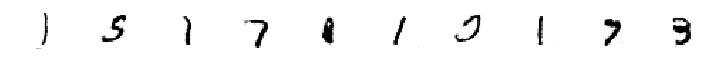

In [21]:
examples=10
dim=(10, 10)
figsize=(10, 10)
noise = np.random.normal(0, 1, size=[examples, random_dim])
generatedImages = generator.predict(noise)

plt.figure(figsize=figsize)
for i in range(generatedImages.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generatedImages[i, :,:,0], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()